## **GO EMOTION TEXT SENTIMENT ANALYSIS**

Dans ce notebook, nous nous attachons à prédire le sentiment d'un texte à l'aide de GoEmotion comme base de départ. Le jeu de données utilisé est IEMOCAP et notre projet se décompose en les parties suivantes :

# Placement dans le bon dossier

In [ ]:
# Si besoin demander accès au dossier RS_Go_emotion_1 à l'adresse bilelletriki88@gmail.com
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/RS_Go_emotion_1

/content/drive/MyDrive/RS_Go_emotion_1


# Installations nécessaires

In [ ]:
!pip install transformers==4.10.0
!pip install datasets

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 3.3 MB 29.1 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 212 kB 41.0 MB/s 
     |████████████████████████████████| 136 kB 40.1 MB/s 
     |████████████████████████████████| 127 kB 46.9 MB/s 
     |████████████████████████████████| 94 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 49.9 MB/s 
     |████████████████████████████████| 271 kB 46.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

# Import

In [ ]:
from transformers.utils.dummy_pt_objects import IBertForMultipleChoice
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
from textwrap import wrap
from torch import nn, optim
from collections import defaultdict
import pickle
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_recall_curve

# Initialisation de nos paramètres et choix du device

In [22]:
# Taille des phrases
MAX_LEN = 30
# une "graine" permettant d'initialiser le moteur aléatoire pour mélanger les datas dont on va tirer une base
# d'apprentissage, de valisation et de test
RANDOM_SEED = 42
# Le nom du modele pre-entrainé
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # case_based_model dans l'article
# Plus ce nb d'exemple dans les batchs est grand, plus l'apprentissage va vite mais avec une perte de précision.
# Théoriquement...
BATCH_SIZE = 16
# nb de fois que l'on va itérer sur la base entiere
EPOCHS = 5
# Le coef d'apprentissage utilisé dans la fct AdamW
CoefApprentissage = 2e-5

#Seuil d'acceptation pour les probabilités prédites pour chaque émotion
GLB_Threshold = 0.25
Flag_train = 1
Flag_inference = 1
# si 0 cela veut dire que l'on prend la base entiere
NbMaxSentences = 0

# detection de la presence d'un GPU
# la variable device sera utilisée ensuite pour envoyer les varaibles et le modèle dans la RAM du GPU pour traitement
GLB_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#Nombre d'émotions
GLB_nb_classes = 9

# Chargement et présentation de nos données

In [ ]:
def create_dataframe1(df):
  data_frame = pd.DataFrame({'content' : [],'sentiment' : []})
  data_frame = df.drop(df[df.emo == "xxx"].index)
  data_frame["content"] = df["phr"]
  emotion = df['emo']
  l = []
  
  for i in emotion:
    if i!='xxx':
      v = [0] * 9
      if i=='ang':
        v[0] = 1
      elif i=='dis':
        v[1] = 1
      elif i=='exc':
        v[2] = 1
      elif i=='fru':
        v[3] = 1
      elif i=='fea':
        v[4] = 1
      elif i=='hap':
        v[5] = 1
      elif i=='sad':
        v[6] = 1
      elif i=='sur':
        v[7] = 1
      elif i=='neu'or str(i) =='nan' or i=='oth':
        v[8] = 1
      l.append(tuple(v))
  data_frame['sentiment'] = l
  return data_frame

fields = ['Column1', 'name', 'genre', 'phr', 'time', 'val', 'dom', 'act', 'emo']
dftr = pd.read_csv('train.csv')
print(dftr.keys())
df_train = create_dataframe1(dftr)

dfva = pd.read_csv('validate.csv')
df_val = create_dataframe1(dfva)

dfte = pd.read_csv('test.csv')
df_test = create_dataframe1(dfte)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'name', 'genre', 'phr', 'time', 'val',
       'dom', 'act', 'emo'],
      dtype='object')


Premier aperçu de l'allure de nos données

<function matplotlib.pyplot.figure>

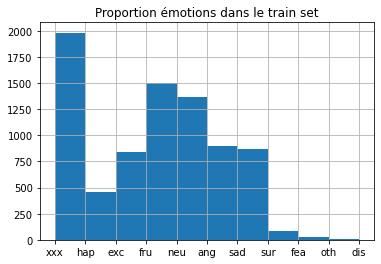

In [ ]:
histtrain = dftr['emo'].hist()
plt.title("Proportion émotions dans le train set")
plt.figure

<function matplotlib.pyplot.figure>

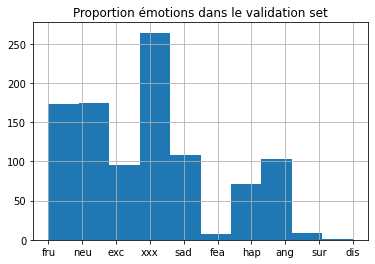

In [ ]:
histtrain = dfva['emo'].hist()
plt.title("Proportion émotions dans le validation set")
plt.figure

<function matplotlib.pyplot.figure>

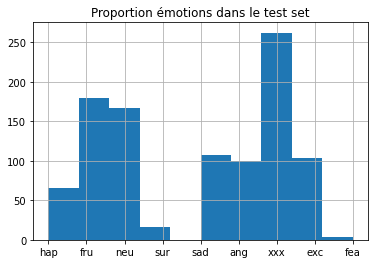

In [ ]:
histtest = dfte['emo'].hist()
plt.title("Proportion émotions dans le test set")
plt.figure

In [19]:
def rs_hotToindices(hotOutputVector):
    outputIndice = []

    # for indexligne, hot in enumerate(hotOutputVector):
    for indice, hot in enumerate(hotOutputVector):
        outputIndice.append([])
        indice_in_one_hot = []
        for indexCol, labelBool in enumerate(hot):
            if labelBool == 1:
                indice_in_one_hot.append(indexCol)
        # outputIndice.append(indice_in_one_hot,0)
        # indice_in_one_hot = torch.tensor(indice_in_one_hot)
        #outputIndice = torch.cat((outputIndice, indice_in_one_hot), 1)
        outputIndice[indice] = indice_in_one_hot

    #outputIndice = torch.tensor(outputIndice)
    #outputIndice = outputIndice.to(GLB_device)
    return (outputIndice)


def rs_indices_to_hot(indice_input):
    nb_classes_out = GLB_nb_classes
    outputHot = []
    for indice in indice_input:
        temp = [0] * nb_classes_out
        temp[indice] = 1
        outputHot.append(temp)
    outputHot = torch.tensor(outputHot)
    outputHot = outputHot.to(GLB_device)
    return (outputHot)

# important de charger la base avec cette fct.
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        # encode_plus est une fct de Hugging Face associée au tokeniser chargé ensuite à partir de la variable
        # PRE_TRAINED_MODEL_NAME
        # elle renvoi des champs qui sont utilisés par le modèle pre-entrainé
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            # padding=True,
            return_attention_mask=True,
            return_tensors='pt',
            # truncation=True,
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


# on charge le tokenizer associé au modèle pre-appris
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Visiblement, le simple fait d'appeler cette fct avec des paramètres permet de parametrer la fct en question même
# si on n'utiise pas son retour
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

tokenizer.encode_plus(
    sample_txt,
    max_length=MAX_LEN,# euh.... c'est pas l avariable MAX_LEN qui devrait être là ???
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)


def File2DataFrame(nameFile):
    # objectif : rendre ne sortie un dataframe pandas pour recoller au code
    # file_name_complete = 'go_emotions/data/' + nameFile + '.tsv'
    with open(nameFile) as f:
        lines = f.readlines()

    phrases_label = []

    for indexLine, ma_ligne in enumerate(lines):
        segments = ma_ligne.split('\t')
        sentence = segments[0]
        # on rajoute des labels nulles en hot coding puisqu'on ne connait pas a priori l'émotion contenue dans la phrase
        phrases_label.append([sentence, [0] * 9])

    output = pd.DataFrame(phrases_label, columns=['content', 'sentiment'])
    return output
def correspIndEmo(ind):
  if(ind == 0):
    return "anger"
  elif(ind==1):
    return "disgusting"
  elif(ind==2):
    return "exciting"
  elif(ind==3):
    return "frustration"
  elif(ind==4):
    return "fear"
  elif(ind==5):
    return "happy"
  elif(ind==6):
    return "sadness"
  elif(ind==7):
    return "surprised"
  elif(ind==8):
    return "others"

def probaclasses(targc,predsc,dicoemo):
  for i in range(len(targc.tolist())):
    ltarg = targc.tolist()
    lpred = predsc.tolist()
    bons = dicoemo[correspIndEmo(ltarg[i].index(1))][0]
    cpts = dicoemo[correspIndEmo(ltarg[i].index(1))][1]
    if(ltarg[i]==lpred[i]):
      dicoemo[correspIndEmo(lpred[i].index(1))][0] =bons+1
    dicoemo[correspIndEmo(ltarg[i].index(1))][1] = cpts+1
  return dicoemo

def Test2Emo(data_loader, n_examples, threshold):
    GLB_model.eval()
    # class_names
    # on evalue la loss pour savoir à quel moment arreter l'apprentissage
    ##losses = []
    ##correct_predictions = 0
    ##compilTargets = np.ndarray(shape=(n_examples, GLB_nb_classes))
    compilPreds = np.ndarray(shape=(n_examples, GLB_nb_classes))
    # A 'interieur d'un batch
    for ii, d in enumerate(data_loader):
        # on met sur le GPU les tokens, maque et labels
        input_ids = d["input_ids"].to(GLB_device)
        attention_mask = d["attention_mask"].to(GLB_device)
        targets = d["targets"].to(GLB_device)
        outputs = GLB_model(
            input_ids=input_ids,
            attention_mask=attention_mask)

        # la taille du dernier batch n'est pas forcément égale à BATCH_SIZE
        Taille_locale_batch = len(outputs)
        preds = np.ndarray(shape=(Taille_locale_batch, GLB_nb_classes))
        # A l'interieur d'un batch, on évalue les predictions correctes
        # attention, la sortie n'est pas entre 0 et 1 puisque la sigmoid est réalisée dans la fct loss!!
        my_softmax = nn.Softmax(dim=1)
        output_soft = my_softmax(outputs)

        for j in range(Taille_locale_batch):
            pred_local = (output_soft[j] > threshold).float() * 1
            titi = pred_local.to('cpu')
            preds[j, :] = titi.numpy()
        compilPreds[ii * BATCH_SIZE:ii * BATCH_SIZE + Taille_locale_batch, :] = preds

    return compilPreds, output_soft

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Création des dataloaders

In [ ]:
# ce dataloader permet de spécifier les batchs et le nb de thread (workers) utilisé en PyTorch pour charger la base
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
    )
    return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

# a partir des trois bases (apprentissages, validation et test, on cree les trous dataloader
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

GLB_nb_exemple_train = len(train_data_loader.batch_sampler.sampler)
GLB_nb_exemple_val = len(val_data_loader.batch_sampler.sampler)
GLB_nb_exemple_test = len(test_data_loader.batch_sampler.sampler)
print(f'nb_exemple_train = {GLB_nb_exemple_train}')
print(f'nb_exemple_val = {GLB_nb_exemple_val}')
print(f'nb_exemple_test = {GLB_nb_exemple_test}')

nb_exemple_train = 6087
nb_exemple_val = 744
nb_exemple_test = 748


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Création du modèle

In [ ]:
# c'est dans cette fct que l'on specifie le modèle qui va etre utilisé.
# Il est associé au tokeniser vu plus haut par la variable PRE_TRAINED_MODEL_NAME
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        # la couche de sortie linéaire
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.out = nn.Sigmoid(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        #RS au lieu de
        # _, pooled_output = self.bert( input_ids=input_ids, attention_mask=attention_mask)
        # on fait.
        # ATTENTION, petite modif avec le code de curiously. Il faut aller chercher les champs last_hidden_state et
        # # pooler_output à la main sinon ça ne fct pas
        output_temp = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output_temp.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


# on cree une instance du model et on la charge sur le gpu s'il existe
GLB_model = SentimentClassifier(GLB_nb_classes)
GLB_model = GLB_model.to(GLB_device)
# On ne fait ni du WarmUp pour aider l'algo a calculer les dérivée ni de coef qui diminue au cours des itérations
# sur les epochs
#Choix de l'optimiseur
GLB_optimizer = AdamW(GLB_model.parameters(), lr=CoefApprentissage, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
GLB_scheduler = get_linear_schedule_with_warmup(
    GLB_optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
#Choix de la loss fonction
#loss_fn = nn.CrossEntropyLoss().to(device)
GLB_loss_fn = nn.BCEWithLogitsLoss().to(GLB_device)
# pour comprendre que la sigmoid est faite dans la fct d'erreur et pas dans les couches
#https://stackoverflow.com/questions/66906884/how-is-pytorchs-class-bcewithlogitsloss-exactly-implemented

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Boucles d'apprentissage et d'inference

In [14]:
def train_one_epoch(data_loader, n_examples, threshold):
    GLB_model.train()
    losses = []
    correct_predictions = 0
    compilTargets = np.ndarray(shape=(n_examples, GLB_nb_classes))
    compilPreds = np.ndarray(shape=(n_examples, GLB_nb_classes))

    # A 'interieur d'un batch
    for ii, d in enumerate(data_loader):
        # on met sur le GPU les tokens, maque et labels
        input_ids = d["input_ids"].to(GLB_device)
        attention_mask = d["attention_mask"].to(GLB_device)
        targets = d["targets"].to(GLB_device)
        outputs = GLB_model(
            input_ids=input_ids,
            attention_mask=attention_mask)

        # pour comprendre pourquoi on est obligé de mettre des cibles binaire en float
        # https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915
        targets = targets.float()
        loss = GLB_loss_fn(outputs, targets)

        # il faut comparer avec rs_prince_old2 pour les predictions correcte avec seuil
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(GLB_model.parameters(), max_norm=1.0)
        GLB_optimizer.step()
        GLB_scheduler.step()
        GLB_optimizer.zero_grad()

        # Dans un cadre multi label, on produit une cible sous la forme d'un hot vecteur
        pouf = targets.cpu()
        targets = pouf.numpy()
        # la taille du dernier batch n'est pas forcément égale à BATCH_SIZE
        Taille_locale_batch = len(outputs)
        preds = np.ndarray(shape=(Taille_locale_batch, GLB_nb_classes))
        # A l'interieur d'un batch, on évalue les predictions correctes
        # attention, la sortie n'est pas entre 0 et 1 puisque la sigmoid est réalisée dans la fct loss!!
        my_softmax = nn.Softmax(dim=1)
        output_soft = my_softmax(outputs)

        for j in range(Taille_locale_batch):
            pred_local = (output_soft[j] > threshold).float() * 1
            titi = pred_local.to('cpu')
            preds[j, :] = titi.numpy()

            #test = (titi.numpy() == targets[j])

            #flag_egal = test.all()
            ltiti = titi.numpy()
            flag_egal = False
            for i in range(len(ltiti)):
              if(ltiti[i] == targets[j][i] and targets[j][i] == 1):
                flag_egal = True
            if (flag_egal == True ):
                correct_predictions += 1.0

        compilTargets[ii * BATCH_SIZE:ii * BATCH_SIZE + Taille_locale_batch, :] = targets
        compilPreds[ii * BATCH_SIZE:ii * BATCH_SIZE + Taille_locale_batch, :] = preds
        
    precision, recall, f1, _ = precision_recall_fscore_support(compilTargets, compilPreds, average=None)
    return correct_predictions / n_examples, np.mean(losses), np.mean(precision), np.mean(recall), np.mean(f1)

cpt=0
def inference_one_epoch(data_loader, n_examples, threshold):
    global cpt
    GLB_model.eval()
    # on evalue la loss pour savoir à quel moment arreter l'apprentissage
    losses = []
    correct_predictions = 0
    compilTargets = np.ndarray(shape=(n_examples, GLB_nb_classes))
    compilPreds = np.ndarray(shape=(n_examples, GLB_nb_classes))
    # A 'interieur d'un batch
    dicoemo = {}
    dicoemo["anger"] = [0,0]
    dicoemo["disgusting"] = [0,0]
    dicoemo["exciting"] = [0,0]
    dicoemo["frustration"] = [0,0]
    dicoemo["fear"] = [0,0]
    dicoemo["happy"] = [0,0]
    dicoemo["sadness"] = [0,0]
    dicoemo["surprised"] = [0,0]
    dicoemo["others"] = [0,0]
    for ii, d in enumerate(data_loader):
        # on met sur le GPU les tokens, maque et labels
        input_ids = d["input_ids"].to(GLB_device)
        attention_mask = d["attention_mask"].to(GLB_device)
        targets = d["targets"].to(GLB_device)
        outputs = GLB_model(
            input_ids=input_ids,
            attention_mask=attention_mask)

        # pour comprendre pourquoi on est obligé de mettre des cibles binaire en float
        # https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915
        targets = targets.float()
        loss = GLB_loss_fn(outputs, targets)

        # il faut comparer avec rs_prince_old2 pour les predictions correcte avec seuil
        losses.append(loss.item())
        #loss.backward()
        #nn.utils.clip_grad_norm_(GLB_model.parameters(), max_norm=1.0)
        #GLB_optimizer.step()
        #GLB_scheduler.step()
        #GLB_optimizer.zero_grad()

        # Dans un cadre multi label, on produit une cible sous la forme d'un hot vecteur
        pouf = targets.cpu()
        targets = pouf.numpy()
        # la taille du dernier batch n'est pas forcément égale à BATCH_SIZE
        Taille_locale_batch = len(outputs)
        preds = np.ndarray(shape=(Taille_locale_batch, GLB_nb_classes))
        # A l'interieur d'un batch, on évalue les predictions correctes
        # attention, la sortie n'est pas entre 0 et 1 puisque la sigmoid est réalisée dans la fct loss!!
        my_softmax = nn.Softmax(dim=1)
        output_soft = my_softmax(outputs)
        
        for j in range(Taille_locale_batch):
          cpt = cpt+1
          pred_local = (output_soft[j] > threshold).float() * 1
          titi = pred_local.to('cpu')
          preds[j, :] = titi.numpy()

          #test = (titi.numpy() == targets[j])
          #flag_egal = test.all()
          ltiti = titi.numpy()
          flag_egal = False
          for i in range(len(ltiti)):
            if(ltiti[i] == targets[j][i] and targets[j][i] == 1):
              flag_egal = True
          if (flag_egal == True):
              correct_predictions += 1.0

        compilTargets[ii * BATCH_SIZE:ii * BATCH_SIZE + Taille_locale_batch, :] = targets
        compilPreds[ii * BATCH_SIZE:ii * BATCH_SIZE + Taille_locale_batch, :] = preds  
        dicoemo = probaclasses(targets,preds,dicoemo)

    precision, recall, f1, _ = precision_recall_fscore_support(compilTargets, compilPreds, average=None)
    # print(f'correct_predictions = {correct_predictions}')
    return correct_predictions / n_examples, np.mean(losses), np.mean(precision), np.mean(recall), np.mean(f1),dicoemo


In [ ]:

# **********************************
#              MAIN
# **********************************

def training(seuil):
  if Flag_train == 1:

      history = defaultdict(list)
      best_accuracy = 0
      best_epoch = 0
      best_acc = 0
      best_losse = 0
      best_precision = 0
      best_recall =0
      Compil_fine_loss = np.ndarray(shape=(EPOCHS*BATCH_SIZE*NbMaxSentences))
      dicemo = {}
      for epoch in range(EPOCHS):
          print(f'Epoch {epoch + 1}/{EPOCHS}')
          print('-' * 10)

          train_acc, train_losse, train_precision, train_recall, train_f1 = train_one_epoch(
              train_data_loader,
              len(df_train),
              seuil)


          val_acc, val_losse, val_precision, val_recall, val_f1,dicemo = inference_one_epoch(
              val_data_loader,
              len(df_val),
              seuil)
          if val_acc > best_accuracy:
              print(f'model meilleur à epoch =  {epoch}')
              torch.save(GLB_model, 'best_model_'+str(seuil) +'.bin')
              best_epoch = epoch



          # des l'accuracy remonte, on sauvegarde le modèle
          # ca changerait quelque chose de faire cela sur la loss ?

          test_acc, test_losse, test_precision, test_recall, test_f1,dicemo = inference_one_epoch(
              test_data_loader,
              len(df_test),
              seuil)

          print(f'TEST accuracy {test_acc} loss {test_losse} precision = {test_precision}, recall = {test_recall}, '
                f'f1 = {test_f1}')

          history['train_loss'].append(train_losse)
          history['val_loss'].append(val_losse)
          history['test_loss'].append(test_losse)

      # Juste pour verifier
      # charge le modèle appris précédemment
      """GLB_model = torch.load('best_model_5dec2021.bin',)


      test_acc, test_losse, test_precision, test_recall, test_f1,dicemo = inference_one_epoch(
          test_data_loader,
          len(df_test),
          seuil)"""

      print(
          f'TEST meilleur modele epoch = {best_epoch}:  accuracy {test_acc} loss {test_losse} precision = {test_precision}, recall = {test_recall}, '
          f'f1 = {test_f1}')
for i in [0.1,0.2,0.25,0.3,0.4]:
  training(i)

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

model meilleur à epoch =  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
TEST meilleur modele epoch = 4:  accuracy 0.6243315508021391 loss 0.2766003657845741 precision = 0.39722388507197015, recall = 0.5371650291504854, f1 = 0.4552764020288159
Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
TEST meilleur modele epoch = 4:  accuracy 0.5588235294117647 loss 0.2766003657845741 precision = 0.43690433497234116, recall = 0.48486408437425865, f1 = 0.45719488387002805
Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
TEST meilleur modele epoch = 4:  accuracy 0.5441176470588235 loss 0.2766003657845741 precision = 0.43527426463232355, recall = 0.43830127893881393, f1 = 0.4309575796804481
Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
TEST meilleur modele epoch = 4:  accuracy 0.5267379679144385 loss 0.2766003657845741 precision = 0.4423715714274502, recall = 0.4232477289610108, f1 = 0.4264309658895748
Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085
Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085
Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085
Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085
Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker numbe

model meilleur à epoch =  4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TEST accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085
TEST meilleur modele epoch = 4:  accuracy 0.5133689839572193 loss 0.2766003657845741 precision = 0.4032259463930153, recall = 0.3712664600006295, f1 = 0.37989266730482085


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Présentation des résultats

In [ ]:
# AFFICHAGE
print(dicemo)
plt.plot(history['train_loss'], label ='losses pendant le train')
plt.plot(history['val_loss'], label ='losses pendant le val')
plt.plot(history['test_loss'], label ='losses pendant le test')
#plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
titre = f'BATCH_SIZE = {BATCH_SIZE} '
plt.title(titre)
plt.ylabel('loss')
plt.xlabel('Batch16, GLB_Threhsold =0.3')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
print("Sur un data set de test de 1010 données nous avons : ")
for i in range(9):
  if dicemo[correspIndEmo(i)][1]!=0:
    proba = 100*dicemo[correspIndEmo(i)][0]/dicemo[correspIndEmo(i)][1]
    print("L'accuracy de la prediction pour le sentiment " + correspIndEmo(i) + " est de " + str(proba)+" pour " + str(dicemo[correspIndEmo(i)][1]) + " données")
  else:
    print("Nous n'avons pas de données sur l'émotion " + correspIndEmo(i))

Sur un data set de test de 1010 données nous avons : 
L'accuracy de la prediction pour le sentiment anger est de 59.0 pour 100 données
Nous n'avons pas de données sur l'émotion disgusting
L'accuracy de la prediction pour le sentiment exciting est de 52.88461538461539 pour 104 données
L'accuracy de la prediction pour le sentiment frustration est de 45.25139664804469 pour 179 données
L'accuracy de la prediction pour le sentiment fear est de 0.0 pour 3 données
L'accuracy de la prediction pour le sentiment happy est de 33.333333333333336 pour 66 données
L'accuracy de la prediction pour le sentiment sadness est de 50.467289719626166 pour 107 données
L'accuracy de la prediction pour le sentiment surprised est de 31.25 pour 16 données
L'accuracy de la prediction pour le sentiment others est de 49.71098265895954 pour 173 données


# Test sur un texte jamais vu 

In [ ]:
df1 = pd.read_csv('nom-fichier.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-4e34b6becf8e>", line 1, in <module>
    df1 = pd.read_csv('nom-fichier.csv')
  File "/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 586, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 482, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 811, in __init__
    self._engine = self._make_engine(self.engine)
  File "/usr/local/lib/python3.7/dist-packages/pandas/io/parsers/readers.py", line 1040, in _make_engine
    return mapping[eng

FileNotFoundError: ignored

In [20]:
# Attention, longuer de la pharse traitée : 30 token sachant qu'il peut y avoir plus d'un token par mot
# phrases contenues dans le fichier texte
# fileData_a_tester

if Flag_inference == 1:
    print(train_data_loader)
    # chargement du modèle
    GLB_model = torch.load('best_model.bin',)
    # chargement de la base à tester
    fileData_a_tester = 'Phrases_a_traiter.txt'
    df_a_tester = File2DataFrame(fileData_a_tester)
    a_tester_data_loader = create_data_loader(df_a_tester, tokenizer, MAX_LEN, 16)
    
    indices_emotionnels, sorties= Test2Emo(
        a_tester_data_loader,
        len(df_a_tester),
        GLB_Threshold)
    # les sorties sont en mode "hot coding"
    # il peut y avoir plus d'une émotions reconnues par phrases testées
    indices_emotionnels = rs_hotToindices(indices_emotionnels)
    # class_names contient l'ensemble des émotions détectables dont le neutre
    print(f' les émotions considérées : {fields}')
    print('')
    for num_phrase, values in enumerate(indices_emotionnels):
        print(f'Phrase {num_phrase} avec les sorties entre 0 et 1 : {sorties[num_phrase]}')
        print(f'les indices des emo dans la pharse entre 0 et NbEmotions-1: {[correspIndEmo(i) for i in values]}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


 les émotions considérées : ['Column1', 'name', 'genre', 'phr', 'time', 'val', 'dom', 'act', 'emo']

Phrase 0 avec les sorties entre 0 et 1 : tensor([0.0039, 0.0043, 0.1188, 0.0705, 0.0223, 0.3936, 0.0085, 0.0072, 0.3710],
       device='cuda:0', grad_fn=<SelectBackward0>)
les indices des emo dans la pharse entre 0 et NbEmotions-1: ['happy', 'others']
Phrase 1 avec les sorties entre 0 et 1 : tensor([0.0014, 0.0016, 0.1285, 0.0098, 0.0044, 0.0485, 0.7980, 0.0023, 0.0055],
       device='cuda:0', grad_fn=<SelectBackward0>)
les indices des emo dans la pharse entre 0 et NbEmotions-1: ['sadness']
Phrase 2 avec les sorties entre 0 et 1 : tensor([0.5653, 0.0021, 0.0123, 0.1731, 0.0020, 0.0071, 0.0045, 0.0424, 0.1911],
       device='cuda:0', grad_fn=<SelectBackward0>)
les indices des emo dans la pharse entre 0 et NbEmotions-1: ['anger']
Phrase 3 avec les sorties entre 0 et 1 : tensor([0.0065, 0.0012, 0.1205, 0.0082, 0.0065, 0.8171, 0.0022, 0.0053, 0.0326],
       device='cuda:0', grad_fn=<Sel